# Team : Akatsuki

## Team Member : JARVVVIS


## Project : Nakshatra ML Prediction Challenge

## Problem Statement :

To predict: whether star is pulsar or not (1 means star is pulsar and 0
means star is not pulsar).

<img src='./assets/pulsar.jpg'>

## Domain Information :

 - Pulsars are a rare type of Neutron star that produce emission detectable even on Earth.
 - As Pulsars rotate their emission beam sweeps across the sky , producing a detectable pattren.
 - Potential signal detection known as a 'candidate' is averaged over many rotations of the pulsar , as determined by length of an observation
 - In the dataset each candidate is a row describe by8 continuous variables
 
 The Training Dataset contains 12528 instances and Test Dataset
contains 5370 examples.

## Analysis :

In [1]:
#load the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import seaborn as sns

import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance
import eli5

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')

In [2]:
#load in the datasets
train_df = pd.read_csv('Train.csv')
test_df = pd.read_csv('Test.csv')

#print out few rows of the dataset
train_df.head()

,Mean_Profile,SD_Profile,Excess_kurtosis_Profile,Skewness_Profile,Mean_Curve,SD_Curve,Excess_kurtosis_curve,Skewness_curve,Pulsar
0,139.937500,53.439035,-0.039384,-0.284501,2.052676,15.381810,10.683568,138.329152,0
1,139.625000,49.633973,-0.184105,-0.015896,0.939799,10.092949,17.078812,367.454955,0
2,106.648438,55.669587,0.377442,-0.594865,1.557692,14.090161,12.268356,171.990291,0
3,83.015625,38.095272,0.514061,2.177837,1.945652,16.407373,9.732946,104.435977,0
4,116.468750,35.632222,0.386352,2.199301,1.541806,14.173109,12.022914,164.296414,0


In [3]:
#print out all the features
columns = list(train_df.columns)
print(train_df.columns)

Index(['Mean_Profile', 'SD_Profile', 'Excess_kurtosis_Profile',
       'Skewness_Profile', 'Mean_Curve', 'SD_Curve', 'Excess_kurtosis_curve',
       'Skewness_curve', 'Pulsar'],
      dtype='object')


1. Mean of the integrated profile. (Mean_Profile)
2. Standard deviation of the integrated profile. (SD_Profile)
3. Excess kurtosis of the integrated profile.(Excess_kurtosis_Profile)
4. Skewness of the integrated profile. (Skewness_Profile)
5. Mean of the DM-SNR curve. (Mean_Curve)
6. Standard deviation of the DM-SNR curve. (SD_Curve)
7. Excess kurtosis of the DM-SNR curve. (Excess_kurtosis_Curve)
8. Skewness of the DM-SNR curve. (Skewness_Curve)

In [4]:
#lets check if there is any missing data
train_df.isna().sum()

Mean_Profile               0
SD_Profile                 0
Excess_kurtosis_Profile    0
Skewness_Profile           0
Mean_Curve                 0
SD_Curve                   0
Excess_kurtosis_curve      0
Skewness_curve             0
Pulsar                     0
dtype: int64

<img src= './assets/relief.gif'> 

In [5]:
#now lets check if there is a class imbalance problem in our dataset or not
train_df.groupby('Pulsar').count()

,Mean_Profile,SD_Profile,Excess_kurtosis_Profile,Skewness_Profile,Mean_Curve,SD_Curve,Excess_kurtosis_curve,Skewness_curve
Pulsar,,,,,,,,
0,11368,11368,11368,11368,11368,11368,11368,11368
1,1160,1160,1160,1160,1160,1160,1160,1160


## Insight: Class Imbalance

class 1 is nearly 10% of class 0 thus we have a class imbalance problem hence the model will just overfit and attain 90% accuracy just by predicting all 0s.
During the time of model Selection we will have to keep in mind this problem and not select model which tend to overfit.

### Uni-variate analysis

In [6]:
#basic
train_df.describe()

,Mean_Profile,SD_Profile,Excess_kurtosis_Profile,Skewness_Profile,Mean_Curve,SD_Curve,Excess_kurtosis_curve,Skewness_curve,Pulsar
count,12528.000000,12528.000000,12528.000000,12528.000000,12528.000000,12528.000000,12528.000000,12528.000000,12528.000000
mean,110.884332,46.444366,0.488968,1.839367,12.566782,26.295402,8.297398,104.431214,0.092593
std,25.925508,6.828295,1.084180,6.308953,29.376282,19.441058,4.481321,105.679753,0.289872
min,5.812500,24.772042,-1.876011,-1.791886,0.213211,7.370432,-3.139270,-1.976976,0.000000
25%,100.771484,42.258655,0.029897,-0.184929,1.929557,14.463905,5.797494,35.343289,0.000000
50%,114.976562,46.875705,0.227795,0.209851,2.808110,18.485294,8.444450,83.064556,0.000000
75%,127.009766,50.913902,0.474663,0.942941,5.430602,28.225653,10.671417,138.517425,0.000000
max,192.617188,98.778911,8.069522,68.101622,222.421405,110.642211,34.539844,1191.000837,1.000000


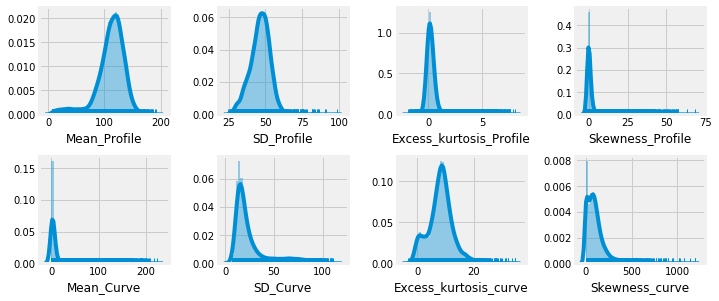

In [7]:
#lets plot some distribution plots to see how the data is distributed in varius features

#define our figure object
plt.figure(figsize=(10,8))

for i in range(len(columns)-1):
    plt.subplot(4,4,i+1)
    sns.distplot(train_df[columns[i]],rug=True);
plt.tight_layout();

#as it can be seen in most of the distributions we have majority values occuring on the lower side
#thus we will have to be careful of outliers

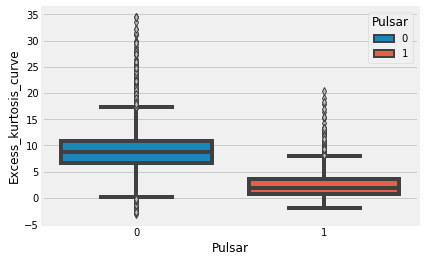

In [8]:
#lets draw some boxplots to get idea of outliers
flierprops = dict(markerfacecolor='0.75', markersize=5,
              linestyle='none')

#Excess_kurtosis_curve
sns.boxplot(x='Pulsar',y='Excess_kurtosis_curve',data=train_df,hue='Pulsar',dodge=False,flierprops=flierprops);

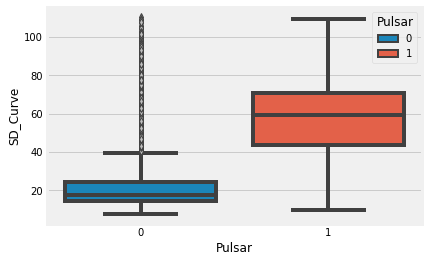

In [9]:
#SD_curve
sns.boxplot(x='Pulsar',y='SD_Curve',data=train_df,hue='Pulsar',dodge=False,flierprops=flierprops);

In [10]:
#lets looks at some more univariate analysis
train_df.groupby('Pulsar').mean()

,Mean_Profile,SD_Profile,Excess_kurtosis_Profile,Skewness_Profile,Mean_Curve,SD_Curve,Excess_kurtosis_curve,Skewness_curve
Pulsar,,,,,,,,
0,116.523609,47.252322,0.212642,0.392823,8.686821,23.204711,8.870147,113.412135
1,55.619423,38.526398,3.196968,16.015501,50.590398,56.584170,2.684458,16.418196


### Bi-variate analysis:

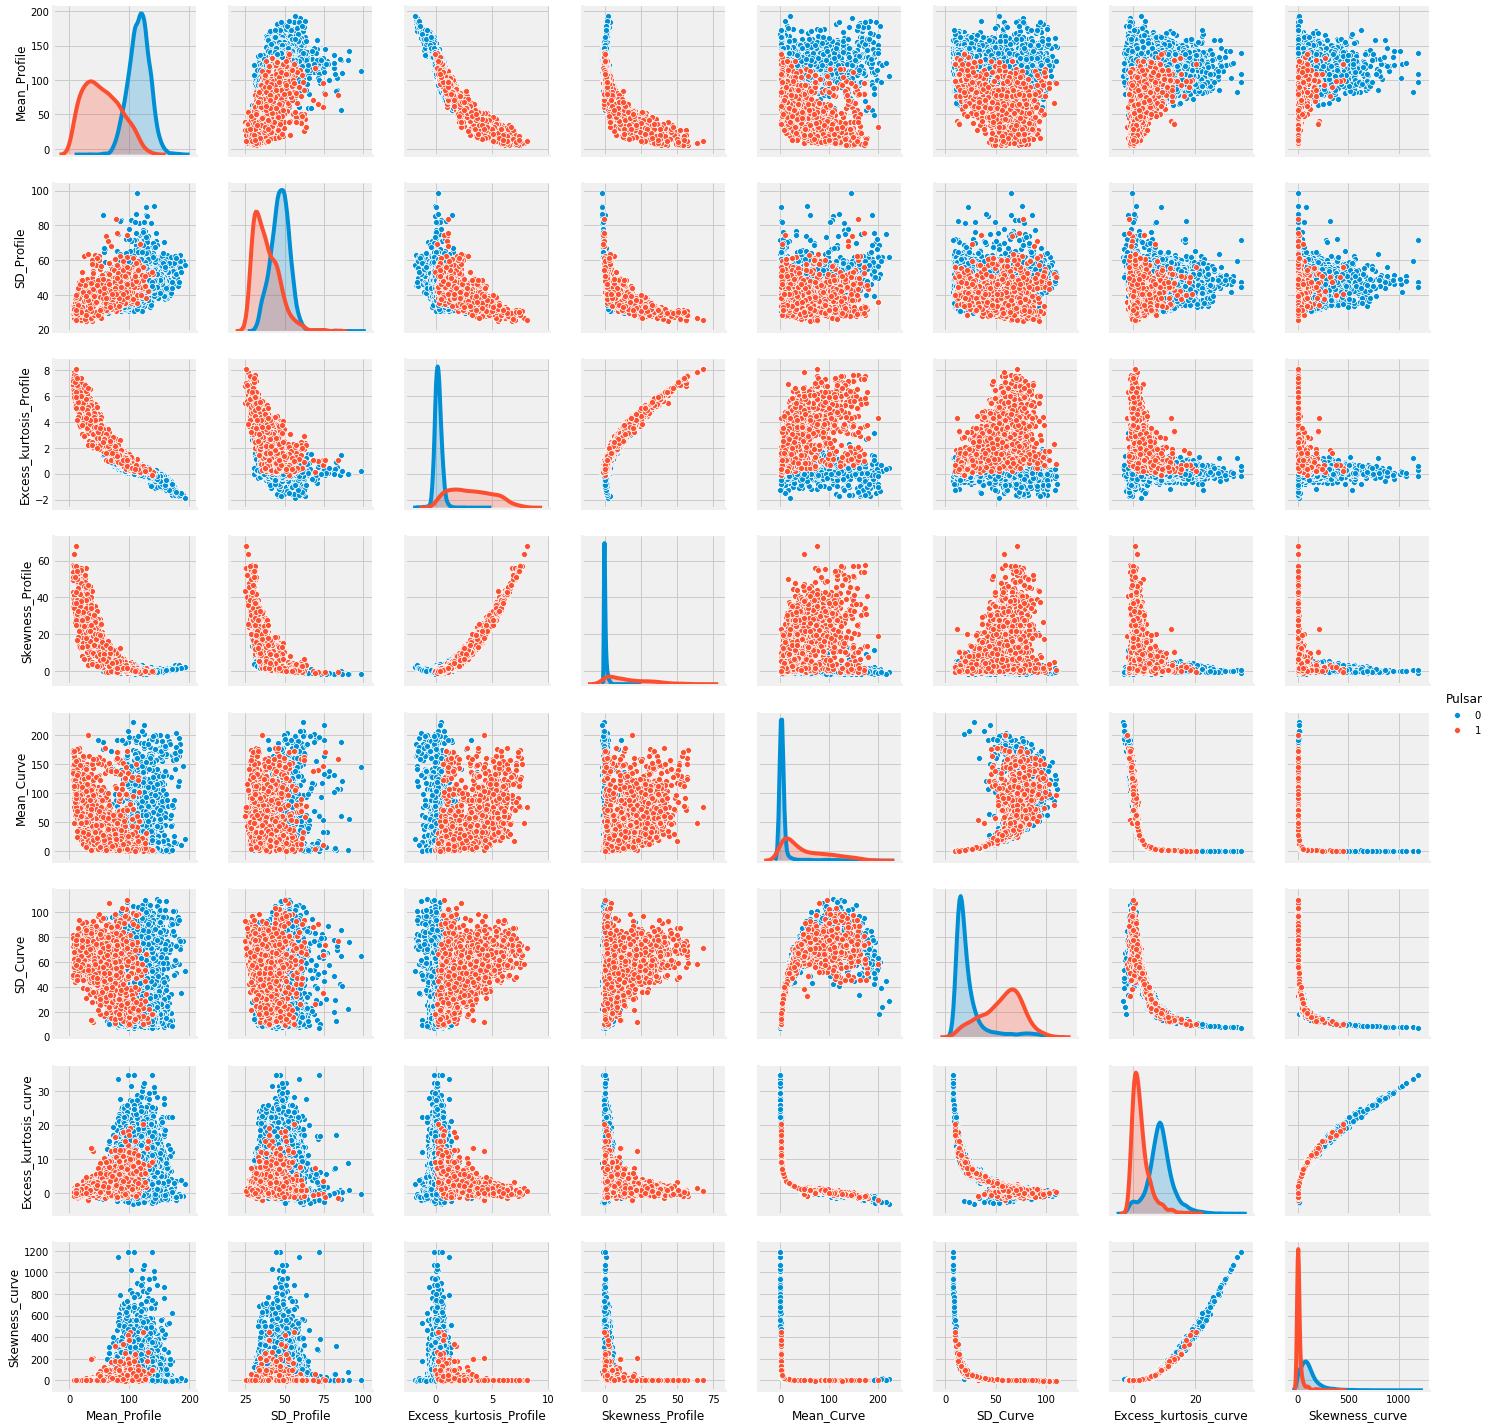

In [11]:
#lets draw a pair plot-correlation matrix to begin with:

features = columns[:-1] #except the pulsar class

#get the paiplot
sns.pairplot(train_df,vars=features,hue='Pulsar');

<img src='./assets/beauty.gif'>

#### We can see that their is some clear relationship between certain pair of features lets draw a Heatmap to investigate more

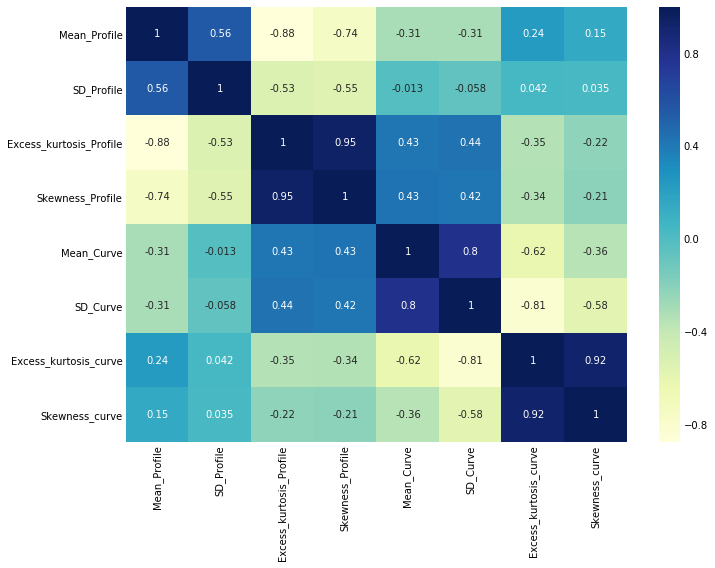

In [12]:
#define X 
X = train_df[features]
#get the correlation
corr = X.corr()

#draw the plot
plt.figure(figsize=(10,8))
sns.heatmap(corr,cmap='YlGnBu',annot=True)
plt.show()

## Insight : 
We can clearly see now in certain feature pairs have very high correlation which clearly implies that there will not be much information gain by using them both so we can while building our model experiment by dropping them to see if we get better results

## Model Building

Now is the time for the fun park a.k.a Model building.
We will have to reject Logistic Regression because:
- Very prone to outliers. 
- Relies at the whole dataset so vvv high varianc
which we cant afford given the nature of our data

We will have to reject Decision Trees because:
- Prone to overfitting in search for better results which on top of class imbalance will give disasterous results

We will basically use ensemble techniques for our model which will ensure that certain outliers dont affect our data as well as random sampling will ensure that overfitting is minimized.

I am not choosing to do any feature selection due to less number of original features. 

In [13]:
#define our X and y variables
X = train_df.drop('Pulsar',axis=1).values
y = train_df['Pulsar'].values

#split the data for training and validation
X_train,X_valid,y_train,y_valid = train_test_split(X,y,test_size=0.20,random_state=0)
print(X_train.shape,X_valid.shape)
print(X_train.mean(),X_valid.mean())


#normalize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

print(X_train_scaled.mean(),X_valid_scaled.mean())

(10022, 8) (2506, 8)
38.909713071375144 38.89104383998718
5.943049773008421e-16 -0.0037710422695166512


### AdaBoost:

In [14]:
#AdaBoost classifier

#baseline classifier
base = DecisionTreeClassifier(max_depth=3)

#adaBoost
ada_1 = AdaBoostClassifier(base_estimator=base,n_estimators=300,learning_rate=1.5,algorithm='SAMME')

In [15]:
#fit the data
ada_1.fit(X_train_scaled,y_train)

AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=1.5, n_estimators=300, random_state=None)

In [16]:
#get the predictions
y_pred = ada_1.predict(X_valid_scaled)
metrics.f1_score(y_valid,y_pred)

0.8854625550660793

without doing much we are getting a F1-score of 0.88 now Lets do some hyper-parameter tuning

## Hyperparameter Tuning

In [17]:
params = {'base_estimator__max_depth':[3,6],
         'n_estimators':[200,300]}

base = DecisionTreeClassifier()

ada_boost = AdaBoostClassifier(base_estimator=base,learning_rate=0.06,algorithm='SAMME')

folds = 3
grid_search_ada = GridSearchCV(ada_boost,cv=folds,param_grid=params,scoring='f1',return_train_score=True,verbose=1)

In [18]:
grid_search_ada.fit(X_train_scaled,y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:   53.7s finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.06, n_estimators=50, random_state=None),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'base_estimator__max_depth': [3, 6], 'n_estimators': [200, 300]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='f1', verbose=1)

In [19]:
# cv results
cv_results = pd.DataFrame(grid_search_ada.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_base_estimator__max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,2.682497,0.216587,0.031250,1.242244e-03,3,200,"{'base_estimator__max_depth': 3, 'n_estimators...",0.885813,0.878632,0.889256,0.884568,0.004425,2,0.889077,0.900169,0.892646,0.893964,0.004623
1,3.879974,0.237196,0.045544,1.243433e-03,3,300,"{'base_estimator__max_depth': 3, 'n_estimators...",0.885813,0.872852,0.889256,0.882641,0.007062,4,0.891892,0.900169,0.893401,0.895154,0.003599
2,4.347704,0.117664,0.037884,7.957732e-04,6,200,"{'base_estimator__max_depth': 6, 'n_estimators...",0.888508,0.865979,0.896552,0.883681,0.012938,3,0.953020,0.965919,0.950378,0.956439,0.006789
3,6.554452,0.167955,0.054853,4.495664e-07,6,300,"{'base_estimator__max_depth': 6, 'n_estimators...",0.890411,0.876289,0.897351,0.888017,0.008763,1,0.951342,0.967635,0.953099,0.957359,0.007302


In [20]:
#best params 300 and 6
base = DecisionTreeClassifier(max_depth=6)

#adaBoost
ada_1 = AdaBoostClassifier(base_estimator=base,n_estimators=300,learning_rate=1,algorithm='SAMME')

In [21]:
ada_1.fit(X_train_scaled,y_train)

AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=1, n_estimators=300, random_state=None)

In [22]:
#make predictions
predictions = ada_1.predict(X_valid_scaled)

In [23]:
metrics.f1_score(y_valid,predictions)

0.9026548672566372

In [24]:
metrics.confusion_matrix(y_valid,predictions)

array([[2258,   13],
       [  31,  204]], dtype=int64)

Not good enough Let's try XGBoost

## XtremeGradientBoosting

In [25]:
#lets first train with default params to see what f1-score are we getting
clf = XGBClassifier()
clf.fit(X_train_scaled,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [26]:
y_pred = clf.predict(X_valid_scaled)
metrics.f1_score(y_valid,y_pred)

0.90625

In [27]:
metrics.confusion_matrix(y_valid,y_pred)

array([[2261,   10],
       [  32,  203]], dtype=int64)

We are getting 0.906 without anything so lets see if we can tune some parameters and improve the accuracy

In [28]:
folds=3

params = {'max_depth':[2,3,4],
           'learning_rate':[0.2,0.3,0.4]}


#grid search
model = GridSearchCV(estimator=clf,
                    param_grid=params,
                    scoring='f1',
                    cv=folds,
                    verbose=1,
                    return_train_score=True)

In [29]:
model.fit(X_train,y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:   12.8s finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': [2, 3, 4], 'learning_rate': [0.2, 0.3, 0.4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='f1', verbose=1)

In [30]:
cv_results = pd.DataFrame(model.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.340435,0.004494,0.005875,0.000183,0.2,2,"{'learning_rate': 0.2, 'max_depth': 2}",0.891938,0.876289,0.896667,0.888299,0.008708,1,0.907861,0.910169,0.901361,0.906464,0.003730
1,0.443491,0.010301,0.007639,0.000465,0.2,3,"{'learning_rate': 0.2, 'max_depth': 3}",0.888124,0.879310,0.895868,0.887767,0.006764,2,0.935919,0.940486,0.925021,0.933809,0.006488
2,0.559514,0.022152,0.009963,0.000015,0.2,4,"{'learning_rate': 0.2, 'max_depth': 4}",0.891938,0.873288,0.892562,0.885931,0.008942,5,0.949580,0.963394,0.949833,0.954269,0.006453
3,0.335440,0.009847,0.005971,0.000019,0.3,2,"{'learning_rate': 0.3, 'max_depth': 2}",0.893471,0.874786,0.893688,0.887316,0.008859,3,0.920339,0.926582,0.913559,0.920160,0.005318
4,0.484372,0.005297,0.007979,0.000813,0.3,3,"{'learning_rate': 0.3, 'max_depth': 3}",0.881647,0.867470,0.891847,0.880321,0.009995,8,0.946925,0.958333,0.950792,0.952017,0.004737
5,0.575136,0.022414,0.010299,0.000476,0.3,4,"{'learning_rate': 0.3, 'max_depth': 4}",0.882453,0.870912,0.884106,0.879158,0.005869,9,0.976821,0.989370,0.976974,0.981055,0.005880
6,0.342093,0.011302,0.006147,0.000626,0.4,2,"{'learning_rate': 0.4, 'max_depth': 2}",0.890411,0.872414,0.898839,0.887222,0.011020,4,0.929721,0.937133,0.921651,0.929502,0.006322
7,0.462098,0.003083,0.008251,0.000384,0.4,3,"{'learning_rate': 0.4, 'max_depth': 3}",0.886598,0.870912,0.892206,0.883239,0.009011,6,0.963272,0.971854,0.960067,0.965064,0.004976
8,0.556511,0.009601,0.009974,0.000815,0.4,4,"{'learning_rate': 0.4, 'max_depth': 4}",0.887372,0.866438,0.891803,0.881872,0.011061,7,0.989336,1.000000,0.991050,0.993462,0.004676


In [31]:
#lr=0.4,max_depth=2

model = XGBClassifier(max_depth=2,learning_rate=0.4)

model.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.4, max_delta_step=0,
       max_depth=2, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [32]:
y_pred = model.predict(X_valid)
metrics.f1_score(y_valid,y_pred)

#pretty much the same accuracy 

0.9006622516556291

In [33]:
metrics.confusion_matrix(y_valid,y_pred)

array([[2257,   14],
       [  31,  204]], dtype=int64)

### Let's now utilize our validation set to do Early Stopping

In [34]:
xgc = XGBClassifier()
eval_set = [(X_valid_scaled,y_valid)]
xgc.fit(X_train_scaled,y_train,eval_metric='logloss',eval_set=eval_set,early_stopping_rounds=30)

[0]	validation_0-logloss:0.604964
Will train until validation_0-logloss hasn't improved in 30 rounds.
[1]	validation_0-logloss:0.532682
[2]	validation_0-logloss:0.472389
[3]	validation_0-logloss:0.421614
[4]	validation_0-logloss:0.378226
[5]	validation_0-logloss:0.341027
[6]	validation_0-logloss:0.308452
[7]	validation_0-logloss:0.280186
[8]	validation_0-logloss:0.255429
[9]	validation_0-logloss:0.233711
[10]	validation_0-logloss:0.214813
[11]	validation_0-logloss:0.198117
[12]	validation_0-logloss:0.183297
[13]	validation_0-logloss:0.169905
[14]	validation_0-logloss:0.158077
[15]	validation_0-logloss:0.147647
[16]	validation_0-logloss:0.138416
[17]	validation_0-logloss:0.130151
[18]	validation_0-logloss:0.122769
[19]	validation_0-logloss:0.116232
[20]	validation_0-logloss:0.110421
[21]	validation_0-logloss:0.105089
[22]	validation_0-logloss:0.100382
[23]	validation_0-logloss:0.096157
[24]	validation_0-logloss:0.092379
[25]	validation_0-logloss:0.088879
[26]	validation_0-logloss:0.0858

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [35]:
y_pred = xgc.predict(X_valid_scaled)
metrics.f1_score(y_valid,y_pred)

0.9111111111111112

In [36]:
metrics.confusion_matrix(y_valid,y_pred)

array([[2261,   10],
       [  30,  205]], dtype=int64)

We are able to increase the score to 0.91 but i dont think any more tricks will increase the score further for corresponding algorithms.

In [37]:
# feature importance
importance = dict(zip(features, xgc.feature_importances_))
importance

{'Mean_Profile': 0.041667383,
 'SD_Profile': 0.050481927,
 'Excess_kurtosis_Profile': 0.6679349,
 'Skewness_Profile': 0.026387531,
 'Mean_Curve': 0.035771903,
 'SD_Curve': 0.09524294,
 'Excess_kurtosis_curve': 0.035321627,
 'Skewness_curve': 0.04719181}

## Model Intrepretablity : XGBoost

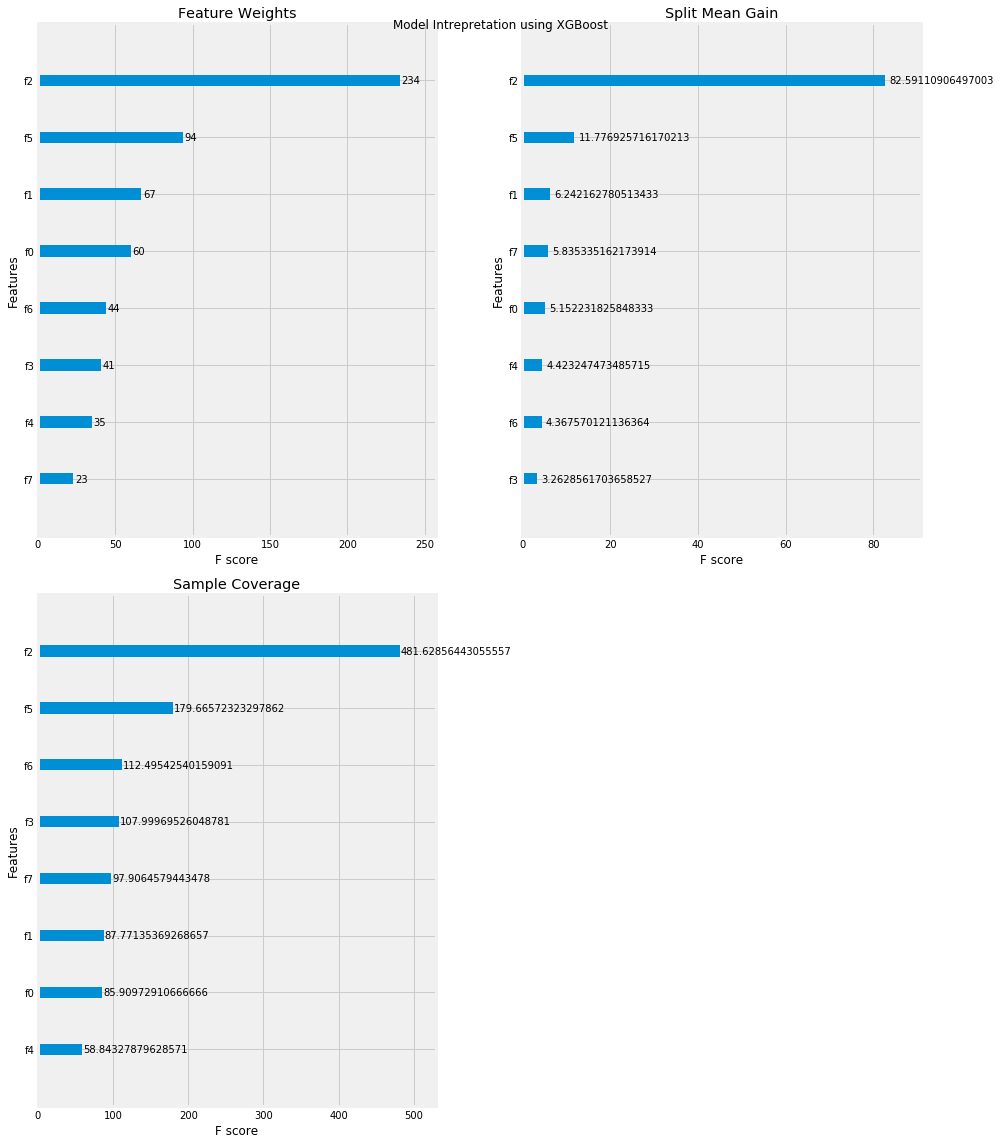

In [38]:
fig = plt.figure(figsize=(14,16))
title = fig.suptitle("Model Intrepretation using XGBoost")

ax1 = fig.add_subplot(2,2,1)
xgb.plot_importance(xgc,importance_type='weight',ax=ax1)
t = ax1.set_title("Feature Weights")

ax2 = fig.add_subplot(2,2,2)
xgb.plot_importance(xgc,importance_type='gain',ax=ax2)
t = ax2.set_title("Split Mean Gain")

ax3 = fig.add_subplot(2,2,3)
xgb.plot_importance(xgc,importance_type='cover',ax=ax3)
t = ax3.set_title("Sample Coverage")

plt.tight_layout()

These basic plots help us understand that why our model works the way it does.

In [39]:
#some necessary changes to work with eli5
f_names=['f0','f1','f2','f3','f4','f5','f6','f7']
xgc_df = train_df[features]
xgc_df.columns = f_names
xgc_df.head()

,f0,f1,f2,f3,f4,f5,f6,f7
0,139.937500,53.439035,-0.039384,-0.284501,2.052676,15.381810,10.683568,138.329152
1,139.625000,49.633973,-0.184105,-0.015896,0.939799,10.092949,17.078812,367.454955
2,106.648438,55.669587,0.377442,-0.594865,1.557692,14.090161,12.268356,171.990291
3,83.015625,38.095272,0.514061,2.177837,1.945652,16.407373,9.732946,104.435977
4,116.468750,35.632222,0.386352,2.199301,1.541806,14.173109,12.022914,164.296414


In [40]:
eli5.show_weights(xgc.get_booster())

Weight,Feature
0.6679,f2
0.0952,f5
0.0505,f1
0.0472,f7
0.0417,f0
0.0358,f4
0.0353,f6
0.0264,f3


In [41]:
data_point=0
print('Actual Label: ',y_valid[data_point])
print('Prediction: ',y_pred[data_point])
eli5.show_prediction(xgc.get_booster(),xgc_df.iloc[data_point],feature_names=f_names,show_feature_values=True)

Actual Label:  0
Prediction:  0


## WOW 
Using this we can see at any point what are the weight contribution and thus understand why are the predictions being made the way they are !! 


## Pull out the big guns!

<img src='./assets/rambo.gif'>

In [42]:
#import necessary libraries
import keras
from keras import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical

Using TensorFlow backend.


In [43]:
n_cols = X_train.shape[1]
train_y = to_categorical(y_train)

In [44]:
#define model
model = Sequential()
early_stop = EarlyStopping(patience=3)

In [45]:
#model architechture
model.add(Dense(160,activation='relu',input_shape=(n_cols,)))
model.add(Dense(80,activation='relu'))
model.add(Dense(2,activation='softmax'))

In [46]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [47]:
#call the fit function on our data
model.fit(X_train_scaled,train_y,epochs=20,callbacks=[early_stop],validation_split=0.2)

Train on 8017 samples, validate on 2005 samples
Epoch 1/20
8017/8017 [==============================] - 24s 3ms/step - loss: 0.1009 - acc: 0.9762 - val_loss: 0.0674 - val_acc: 0.9786
Epoch 2/20
8017/8017 [==============================] - 1s 115us/step - loss: 0.0733 - acc: 0.9803 - val_loss: 0.0631 - val_acc: 0.9791
Epoch 3/20
8017/8017 [==============================] - 1s 78us/step - loss: 0.0723 - acc: 0.9795 - val_loss: 0.0616 - val_acc: 0.9791
Epoch 4/20
8017/8017 [==============================] - 1s 90us/step - loss: 0.0691 - acc: 0.9808 - val_loss: 0.0629 - val_acc: 0.9800
Epoch 5/20
8017/8017 [==============================] - 1s 82us/step - loss: 0.0693 - acc: 0.9812 - val_loss: 0.0607 - val_acc: 0.9810
Epoch 6/20
8017/8017 [==============================] - 1s 80us/step - loss: 0.0679 - acc: 0.9808 - val_loss: 0.0596 - val_acc: 0.9796
Epoch 7/20
8017/8017 [==============================] - 1s 80us/step - loss: 0.0669 - acc: 0.9805 - val_loss: 0.0602 - val_acc: 0.9800
Epoch 

In [48]:
#grab the one hot encoded predicitons
predict = model.predict(X_valid_scaled)

In [49]:
#lil code to convert the one hot encoded prediction to normal 
ans = []
for data in predict:
    if data[0]>data[1]:
        ans.append(0)
    else:
        ans.append(1)
ans = np.array(ans)

In [50]:
metrics.f1_score(y_valid,ans)

0.899357601713062

In [51]:
metrics.confusion_matrix(y_valid,ans)

array([[2249,   22],
       [  25,  210]], dtype=int64)

#### XGBoost with early stopping is the best choice.

In [52]:
#our test dataset
test_df.head()

,Mean_Profile,SD_Profile,Excess_kurtosis_Profile,Skewness_Profile,Mean_Curve,SD_Curve,Excess_kurtosis_curve,Skewness_curve
0,114.531250,43.977078,0.348897,0.962387,1.548495,13.955201,10.927910,140.540754
1,108.617188,45.805656,0.500210,0.328802,2.734950,20.424979,8.552659,78.183891
2,105.546875,41.360998,0.219053,0.555135,2.469900,14.960704,9.051707,103.517934
3,94.507812,33.818910,0.401374,3.052846,2.749164,21.541023,8.608826,78.096962
4,122.562500,45.473679,0.062036,0.417907,2.964047,21.711191,8.214987,71.957368


In [53]:
X_test = test_df.values
#normalize X_test
X_test_scaled  = scaler.transform(X_test)

In [54]:
#predictions
final_prediction = xgc.predict(X_test_scaled)
final_prediction.shape

(5370,)

In [55]:
size = X_test.shape[0]
predict_df = {}
for i in range(1,size+1):
    predict_df[i]=final_prediction[i-1]
idx = ['Id',"Predictions"]

In [56]:
#save into csv file
(pd.DataFrame(list(predict_df.items()),
                      columns=idx)).to_csv('Predictions.csv', encoding='utf-8', index=False)

## Final Thoughts:
Though we were able to achieve outstanding accuracy 97-98% and decent enough F1-score 0.911 still there is a lot that could have been done but due to finiteness of time this was the best I could come up to.

__Further Work__:
1. Do more Hypertuning on Nueral Network with methods such as GridSearch and Random Search
2. Do some feature extraction and see if we get better results.
3. Do more work on Model Intrepretability using frameworks such as LIME,SHAP,skater

## Lastly... 

I would like to congratulate Team Nakshatra on organizing such a brilliant and innovative competition.Though I never have wondered about the world over our heads , This weekend took me on a beautiful ride where I found myself spending hours watching Black Hole videos or reading articles about Neutron Stars and obviously learnt alot of new things reagarding ML/DL. 

**Keep up the good work**

P.S. - Ignore any grammatical error please :P

<img src='./assets/thank.gif'>